In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
IMAGE_SIZE = 28
PIXEL_COUNT = IMAGE_SIZE ** 2

TRAIN_DATA_PATH = '../input/train.csv'
TEST_DATA_PATH = '../input/test.csv'
WEIGHTS_PATH = '../output/weights.h5'
PREDICTIONS_PATH = '../output/predictions.csv'

In [8]:
full_train_data = pd.read_csv(TRAIN_DATA_PATH).as_matrix()

display(full_train_data[:5])

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [530]:
train_data = full_train_data[:1000]
train_labels, train_data = train_data[:, :1].flatten(), train_data[:, 1:]

display(train_labels[:5])
display(train_data[:5])

array([1, 0, 1, 4, 0])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [531]:
train_images = train_data.reshape(train_data.shape[0], IMAGE_SIZE, IMAGE_SIZE)
train_images[:5]

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0]

In [532]:
def display_images(images, labels):
    figure = plt.figure(figsize=(12, 24))
    
    for i, (label, image) in enumerate(zip(labels, images)):
        image_plot = figure.add_subplot(1, len(images), i + 1)
        image_plot.set_title(label, fontsize=18)
        image_plot.imshow(image, interpolation=None, cmap='gray')

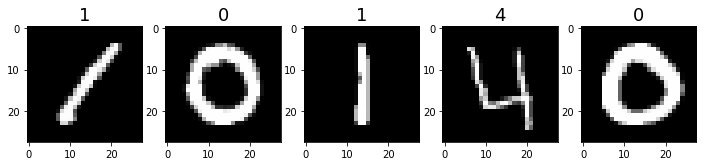

In [533]:
display_images(train_images[:5], train_labels[:5])

(800, 28, 28)

(200, 28, 28)

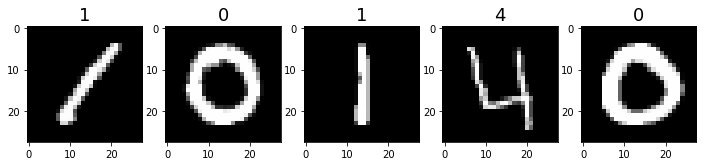

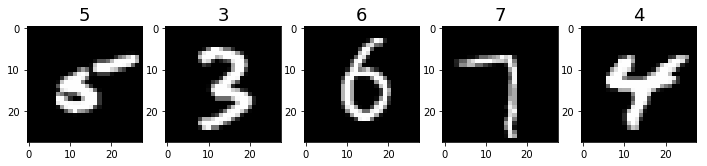

In [534]:
validation_size = int(len(train_images) * 0.2)
validation_images = train_images[-validation_size:]
validation_labels = train_labels[-validation_size:]
train_images = train_images[:-validation_size]
train_labels = train_labels[:-validation_size]

display(train_images.shape)
display_images(train_images[:5], train_labels[:5])
display(validation_images.shape)
display_images(validation_images[:5], validation_labels[:5])

## Simple model

In [535]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

simple = Sequential([
    # Preprocess
    Flatten(input_shape=(IMAGE_SIZE, IMAGE_SIZE)),
    
    # Input layer
    Dense(32),
    Activation('relu'),
    
    # Output layer
    Dense(10),
    Activation('softmax'),
])

simple.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_50 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_113 (Dense)            (None, 32)                25120     
_________________________________________________________________
activation_113 (Activation)  (None, 32)                0         
_________________________________________________________________
dense_114 (Dense)            (None, 10)                330       
_________________________________________________________________
activation_114 (Activation)  (None, 10)                0         
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [536]:
simple.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [537]:
from keras import utils

# Convert labels to categorical one-hot encoding
train_labels_onehot = utils.to_categorical(train_labels, num_classes=10)
validation_labels_onehot = utils.to_categorical(validation_labels, num_classes=10)

In [538]:
simple.fit(
    train_images,
    train_labels_onehot,
    epochs=5,
    batch_size=32,
    validation_data=(validation_images, validation_labels_onehot),
)

Train on 800 samples, validate on 200 samples
Epoch 1/5
800/800 [==============================] - 0s - loss: 13.9529 - acc: 0.1313 - val_loss: 13.1362 - val_acc: 0.1850
Epoch 2/5
800/800 [==============================] - 0s - loss: 13.3552 - acc: 0.1700 - val_loss: 12.7637 - val_acc: 0.2050
Epoch 3/5
800/800 [==============================] - 0s - loss: 13.2021 - acc: 0.1800 - val_loss: 12.6981 - val_acc: 0.2100
Epoch 4/5
800/800 [==============================] - 0s - loss: 13.2113 - acc: 0.1800 - val_loss: 12.9751 - val_acc: 0.1950
Epoch 5/5
800/800 [==============================] - 0s - loss: 13.3395 - acc: 0.1712 - val_loss: 12.8945 - val_acc: 0.2000


In [539]:
simple.optimizer.lr *= 10
simple.fit(
    train_images,
    train_labels_onehot,
    epochs=5,
    batch_size=32,
    validation_data=(validation_images, validation_labels_onehot),
)

Train on 800 samples, validate on 200 samples
Epoch 1/5
800/800 [==============================] - 0s - loss: 13.3642 - acc: 0.1700 - val_loss: 12.6527 - val_acc: 0.2150
Epoch 2/5
800/800 [==============================] - 0s - loss: 12.8313 - acc: 0.1975 - val_loss: 11.7331 - val_acc: 0.2650
Epoch 3/5
800/800 [==============================] - 0s - loss: 12.0679 - acc: 0.2475 - val_loss: 10.9316 - val_acc: 0.3200
Epoch 4/5
800/800 [==============================] - 0s - loss: 11.7872 - acc: 0.2687 - val_loss: 11.0409 - val_acc: 0.3150
Epoch 5/5
800/800 [==============================] - 0s - loss: 11.8569 - acc: 0.2625 - val_loss: 11.1962 - val_acc: 0.3000


## Simple + BatchNorm

In [540]:
from keras.layers import BatchNormalization

simple_bn = Sequential([
    # Preprocess
    Flatten(input_shape=(IMAGE_SIZE, IMAGE_SIZE)),
    BatchNormalization(),
    
    # Input layer
    Dense(32),
    Activation('relu'),
    BatchNormalization(),
    
    # Output layer
    Dense(10),
    Activation('softmax'),
])

simple_bn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
simple_bn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_51 (Flatten)         (None, 784)               0         
_________________________________________________________________
batch_normalization_79 (Batc (None, 784)               3136      
_________________________________________________________________
dense_115 (Dense)            (None, 32)                25120     
_________________________________________________________________
activation_115 (Activation)  (None, 32)                0         
_________________________________________________________________
batch_normalization_80 (Batc (None, 32)                128       
_________________________________________________________________
dense_116 (Dense)            (None, 10)                330       
_________________________________________________________________
activation_116 (Activation)  (None, 10)                0         
Total para

In [541]:
simple_bn.fit(
    train_images,
    train_labels_onehot,
    epochs=5,
    batch_size=32,
    validation_data=(validation_images, validation_labels_onehot),
)

Train on 800 samples, validate on 200 samples
Epoch 1/5
800/800 [==============================] - 0s - loss: 1.8806 - acc: 0.3863 - val_loss: 1.6673 - val_acc: 0.5650
Epoch 2/5
800/800 [==============================] - 0s - loss: 0.8614 - acc: 0.7450 - val_loss: 1.1050 - val_acc: 0.6900
Epoch 3/5
800/800 [==============================] - 0s - loss: 0.6059 - acc: 0.8463 - val_loss: 0.9177 - val_acc: 0.7400
Epoch 4/5
800/800 [==============================] - 0s - loss: 0.4870 - acc: 0.8912 - val_loss: 0.8272 - val_acc: 0.7600
Epoch 5/5
800/800 [==============================] - 0s - loss: 0.4087 - acc: 0.9125 - val_loss: 0.7529 - val_acc: 0.7800


In [542]:
simple_bn.optimizer.lr *= 10
simple_bn.fit(
    train_images,
    train_labels_onehot,
    epochs=5,
    batch_size=32,
    validation_data=(validation_images, validation_labels_onehot),
)

Train on 800 samples, validate on 200 samples
Epoch 1/5
800/800 [==============================] - 0s - loss: 0.3279 - acc: 0.9337 - val_loss: 0.7422 - val_acc: 0.7850
Epoch 2/5
800/800 [==============================] - 0s - loss: 0.2881 - acc: 0.9500 - val_loss: 0.7538 - val_acc: 0.7950
Epoch 3/5
800/800 [==============================] - 0s - loss: 0.2491 - acc: 0.9612 - val_loss: 0.7629 - val_acc: 0.8150
Epoch 4/5
800/800 [==============================] - 0s - loss: 0.2210 - acc: 0.9713 - val_loss: 0.8150 - val_acc: 0.8100
Epoch 5/5
800/800 [==============================] - 0s - loss: 0.1880 - acc: 0.9662 - val_loss: 0.8260 - val_acc: 0.8100


 32/200 [===>..........................] - ETA: 0s

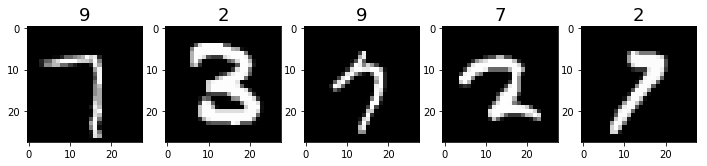

In [543]:
predicted_labels = simple_bn.predict_classes(validation_images, batch_size=32)
errors = np.where(validation_labels != predicted_labels)[0][:5]
display_images(validation_images[errors], predicted_labels[errors])

## Simple + Data Augumentation

In [544]:
# same as simple_bn
simple_aug = Sequential([
    # Preprocess
    Flatten(input_shape=(IMAGE_SIZE, IMAGE_SIZE)),
    BatchNormalization(),
    
    # Input layer
    Dense(32),
    Activation('relu'),
    BatchNormalization(),
    
    # Output layer
    Dense(10),
    Activation('softmax'),
])

simple_aug.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
simple_aug.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_52 (Flatten)         (None, 784)               0         
_________________________________________________________________
batch_normalization_81 (Batc (None, 784)               3136      
_________________________________________________________________
dense_117 (Dense)            (None, 32)                25120     
_________________________________________________________________
activation_117 (Activation)  (None, 32)                0         
_________________________________________________________________
batch_normalization_82 (Batc (None, 32)                128       
_________________________________________________________________
dense_118 (Dense)            (None, 10)                330       
_________________________________________________________________
activation_118 (Activation)  (None, 10)                0         
Total para

In [545]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=20,
    zoom_range=(0.9, 1.4),
)

def batches(images, labels, batch_size=32):
    while True:
        for i in range(0, len(images), batch_size):
            yield images[i:i+batch_size], labels[i:i+batch_size]

def generate(images, labels, batch_size=32):
    images = np.expand_dims(images, axis=3)
    batches = image_generator.flow(images, labels, batch_size=batch_size)
    for batch_images, batch_labels in batches:
        yield np.squeeze(batch_images, axis=3), batch_labels

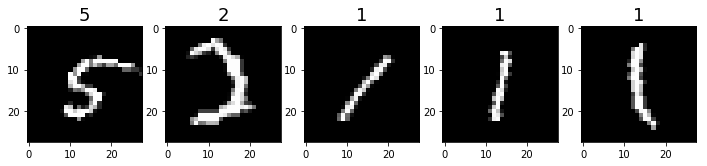

In [546]:
aug_images, aug_labels = next(generate(train_images, train_labels, 5))
display_images(aug_images, aug_labels)

In [547]:
from math import ceil

simple_aug.fit_generator(
    generate(train_images, train_labels_onehot, batch_size=32),
    steps_per_epoch=ceil(len(train_images) / 32) * 4,
    epochs=5,
    validation_data=batches(validation_images, validation_labels_onehot, batch_size=25),
    validation_steps=ceil(len(validation_images) / 25),
)

Epoch 1/5
100/100 [==============================] - 1s - loss: 1.3732 - acc: 0.5650 - val_loss: 1.0509 - val_acc: 0.7350
Epoch 2/5
100/100 [==============================] - 0s - loss: 0.8149 - acc: 0.7522 - val_loss: 0.7806 - val_acc: 0.8550
Epoch 3/5
100/100 [==============================] - 1s - loss: 0.6912 - acc: 0.7869 - val_loss: 0.6455 - val_acc: 0.8650
Epoch 4/5
100/100 [==============================] - 0s - loss: 0.5953 - acc: 0.8213 - val_loss: 0.6116 - val_acc: 0.8650
Epoch 5/5
100/100 [==============================] - 1s - loss: 0.5515 - acc: 0.8341 - val_loss: 0.6132 - val_acc: 0.8500


In [548]:
simple_aug.optimizer.lr *= 10
simple_aug.fit_generator(
    generate(train_images, train_labels_onehot, batch_size=32),
    steps_per_epoch=ceil(len(train_images) / 32) * 4,
    epochs=5,
    validation_data=batches(validation_images, validation_labels_onehot, batch_size=25),
    validation_steps=ceil(len(validation_images) / 25),
)

Epoch 1/5
100/100 [==============================] - 1s - loss: 0.4992 - acc: 0.8519 - val_loss: 0.6615 - val_acc: 0.8900
Epoch 2/5
100/100 [==============================] - 1s - loss: 0.4683 - acc: 0.8581 - val_loss: 0.6696 - val_acc: 0.8450
Epoch 3/5
100/100 [==============================] - 1s - loss: 0.4481 - acc: 0.8569 - val_loss: 0.6495 - val_acc: 0.8400
Epoch 4/5
100/100 [==============================] - 1s - loss: 0.4270 - acc: 0.8612 - val_loss: 0.6457 - val_acc: 0.8500
Epoch 5/5
100/100 [==============================] - 1s - loss: 0.3883 - acc: 0.8772 - val_loss: 0.6000 - val_acc: 0.8550


 32/200 [===>..........................] - ETA: 0s

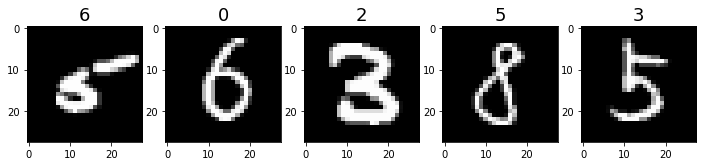

In [549]:
predicted_labels = simple_aug.predict_classes(validation_images, batch_size=32)
errors = np.where(validation_labels != predicted_labels)[0][:5]
display_images(validation_images[errors], predicted_labels[errors])

## Simple + Dropout

In [550]:
from keras.layers import Dropout

simple_do = Sequential([
    # Preprocess
    Flatten(input_shape=(IMAGE_SIZE, IMAGE_SIZE)),
    BatchNormalization(),
    
    # Input layer
    Dense(32),
    Activation('relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    # Output layer
    Dense(10),
    Activation('softmax'),
])

simple_do.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
simple_do.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_53 (Flatten)         (None, 784)               0         
_________________________________________________________________
batch_normalization_83 (Batc (None, 784)               3136      
_________________________________________________________________
dense_119 (Dense)            (None, 32)                25120     
_________________________________________________________________
activation_119 (Activation)  (None, 32)                0         
_________________________________________________________________
batch_normalization_84 (Batc (None, 32)                128       
_________________________________________________________________
dropout_23 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_120 (Dense)            (None, 10)                330       
__________

In [551]:
simple_do.fit(
    train_images,
    train_labels_onehot,
    epochs=5,
    batch_size=32,
    validation_data=(validation_images, validation_labels_onehot),
)

Train on 800 samples, validate on 200 samples
Epoch 1/5
800/800 [==============================] - 0s - loss: 2.5379 - acc: 0.2462 - val_loss: 2.1221 - val_acc: 0.5100
Epoch 2/5
800/800 [==============================] - 0s - loss: 1.4522 - acc: 0.5250 - val_loss: 1.3893 - val_acc: 0.6550
Epoch 3/5
800/800 [==============================] - 0s - loss: 1.1373 - acc: 0.6200 - val_loss: 1.1268 - val_acc: 0.7450
Epoch 4/5
800/800 [==============================] - 0s - loss: 0.9790 - acc: 0.7075 - val_loss: 1.0202 - val_acc: 0.7450
Epoch 5/5
800/800 [==============================] - 0s - loss: 0.8474 - acc: 0.7312 - val_loss: 0.9620 - val_acc: 0.7750


In [552]:
# simple_do.optimizer.lr *= 10
simple_do.fit(
    train_images,
    train_labels_onehot,
    epochs=5,
    batch_size=32,
    validation_data=(validation_images, validation_labels_onehot),
)

Train on 800 samples, validate on 200 samples
Epoch 1/5
800/800 [==============================] - 0s - loss: 0.7748 - acc: 0.7512 - val_loss: 0.9146 - val_acc: 0.8200
Epoch 2/5
800/800 [==============================] - 0s - loss: 0.7116 - acc: 0.7987 - val_loss: 0.9024 - val_acc: 0.8150
Epoch 3/5
800/800 [==============================] - 0s - loss: 0.6408 - acc: 0.7950 - val_loss: 0.8854 - val_acc: 0.8200
Epoch 4/5
800/800 [==============================] - 0s - loss: 0.5855 - acc: 0.8188 - val_loss: 0.8839 - val_acc: 0.8200
Epoch 5/5
800/800 [==============================] - 0s - loss: 0.5675 - acc: 0.8275 - val_loss: 0.9097 - val_acc: 0.8200


 32/200 [===>..........................] - ETA: 0s

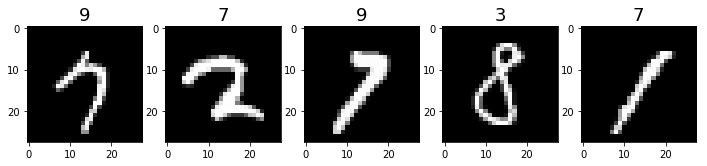

In [553]:
predicted_labels = simple_do.predict_classes(validation_images, batch_size=32)
errors = np.where(validation_labels != predicted_labels)[0][:5]
display_images(validation_images[errors], predicted_labels[errors])

## Hidden

In [554]:
hidden = Sequential([
    # Preprocess
    Flatten(input_shape=(IMAGE_SIZE, IMAGE_SIZE)),
    BatchNormalization(),
    
    # Input layer
    Dense(32),
    Activation('relu'),
    BatchNormalization(),
    
    # Hidden layer
    Dense(32),
    Activation('relu'),
    BatchNormalization(),
    
    # Output layer
    Dense(10),
    Activation('softmax'),
])

hidden.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
hidden.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_54 (Flatten)         (None, 784)               0         
_________________________________________________________________
batch_normalization_85 (Batc (None, 784)               3136      
_________________________________________________________________
dense_121 (Dense)            (None, 32)                25120     
_________________________________________________________________
activation_121 (Activation)  (None, 32)                0         
_________________________________________________________________
batch_normalization_86 (Batc (None, 32)                128       
_________________________________________________________________
dense_122 (Dense)            (None, 32)                1056      
_________________________________________________________________
activation_122 (Activation)  (None, 32)                0         
__________

In [555]:
hidden.fit(
    train_images,
    train_labels_onehot,
    epochs=5,
    batch_size=32,
    validation_data=(validation_images, validation_labels_onehot),
)

Train on 800 samples, validate on 200 samples
Epoch 1/5
800/800 [==============================] - 0s - loss: 2.2591 - acc: 0.2637 - val_loss: 2.3094 - val_acc: 0.3550
Epoch 2/5
800/800 [==============================] - 0s - loss: 1.2609 - acc: 0.6250 - val_loss: 1.6086 - val_acc: 0.5450
Epoch 3/5
800/800 [==============================] - 0s - loss: 0.9378 - acc: 0.7575 - val_loss: 1.3140 - val_acc: 0.6800
Epoch 4/5
800/800 [==============================] - 0s - loss: 0.7026 - acc: 0.8550 - val_loss: 1.1358 - val_acc: 0.7650
Epoch 5/5
800/800 [==============================] - 0s - loss: 0.5408 - acc: 0.8950 - val_loss: 1.0521 - val_acc: 0.7800


In [556]:
hidden.optimizer.lr *= 10
hidden.fit(
    train_images,
    train_labels_onehot,
    epochs=5,
    batch_size=32,
    validation_data=(validation_images, validation_labels_onehot),
)

Train on 800 samples, validate on 200 samples
Epoch 1/5
800/800 [==============================] - 0s - loss: 0.4585 - acc: 0.9125 - val_loss: 1.0197 - val_acc: 0.8050
Epoch 2/5
800/800 [==============================] - 0s - loss: 0.3853 - acc: 0.9312 - val_loss: 1.0043 - val_acc: 0.8000
Epoch 3/5
800/800 [==============================] - 0s - loss: 0.3240 - acc: 0.9387 - val_loss: 0.9873 - val_acc: 0.8100
Epoch 4/5
800/800 [==============================] - 0s - loss: 0.2474 - acc: 0.9625 - val_loss: 0.9817 - val_acc: 0.8250
Epoch 5/5
800/800 [==============================] - 0s - loss: 0.2219 - acc: 0.9662 - val_loss: 0.9612 - val_acc: 0.8350


 32/200 [===>..........................] - ETA: 0s

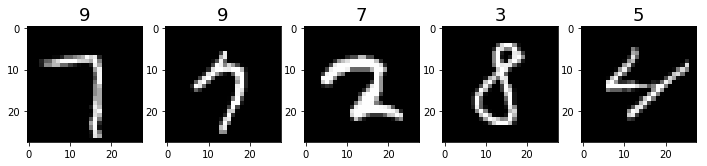

In [557]:
predicted_labels = hidden.predict_classes(validation_images, batch_size=32)
errors = np.where(validation_labels != predicted_labels)[0][:5]
display_images(validation_images[errors], predicted_labels[errors])

## Hidden + Dropout

In [558]:
hidden_do = Sequential([
    # Preprocess
    Flatten(input_shape=(IMAGE_SIZE, IMAGE_SIZE)),
    BatchNormalization(),
    
    # Input layer
    Dense(32),
    Activation('relu'),
    BatchNormalization(),
    Dropout(0.25),
    
    # Hidden layer
    Dense(32),
    Activation('relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    # Output layer
    Dense(10),
    Activation('softmax'),
])

hidden_do.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
hidden_do.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_55 (Flatten)         (None, 784)               0         
_________________________________________________________________
batch_normalization_88 (Batc (None, 784)               3136      
_________________________________________________________________
dense_124 (Dense)            (None, 32)                25120     
_________________________________________________________________
activation_124 (Activation)  (None, 32)                0         
_________________________________________________________________
batch_normalization_89 (Batc (None, 32)                128       
_________________________________________________________________
dropout_24 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_125 (Dense)            (None, 32)                1056      
__________

In [559]:
hidden_do.fit(
    train_images,
    train_labels_onehot,
    epochs=5,
    batch_size=32,
    validation_data=(validation_images, validation_labels_onehot),
)

Train on 800 samples, validate on 200 samples
Epoch 1/5
800/800 [==============================] - 0s - loss: 2.7886 - acc: 0.2038 - val_loss: 2.2482 - val_acc: 0.3150
Epoch 2/5
800/800 [==============================] - 0s - loss: 1.9664 - acc: 0.3550 - val_loss: 1.5912 - val_acc: 0.4800
Epoch 3/5
800/800 [==============================] - 0s - loss: 1.5698 - acc: 0.4512 - val_loss: 1.3672 - val_acc: 0.6400
Epoch 4/5
800/800 [==============================] - 0s - loss: 1.3936 - acc: 0.5212 - val_loss: 1.1920 - val_acc: 0.6950
Epoch 5/5
800/800 [==============================] - 0s - loss: 1.3075 - acc: 0.5700 - val_loss: 1.0803 - val_acc: 0.7650


In [560]:
hidden_do.optimizer.lr *= 10
hidden_do.fit(
    train_images,
    train_labels_onehot,
    epochs=5,
    batch_size=32,
    validation_data=(validation_images, validation_labels_onehot),
)

Train on 800 samples, validate on 200 samples
Epoch 1/5
800/800 [==============================] - 0s - loss: 1.2290 - acc: 0.6000 - val_loss: 0.9742 - val_acc: 0.8050
Epoch 2/5
800/800 [==============================] - 0s - loss: 1.0832 - acc: 0.6562 - val_loss: 0.9110 - val_acc: 0.8150
Epoch 3/5
800/800 [==============================] - 0s - loss: 1.0096 - acc: 0.6687 - val_loss: 0.8769 - val_acc: 0.8200
Epoch 4/5
800/800 [==============================] - ETA: 0s - loss: 0.9281 - acc: 0.703 - 0s - loss: 0.9218 - acc: 0.7112 - val_loss: 0.9172 - val_acc: 0.8450
Epoch 5/5
800/800 [==============================] - 0s - loss: 0.8531 - acc: 0.7188 - val_loss: 0.9112 - val_acc: 0.8550


 32/200 [===>..........................] - ETA: 0s

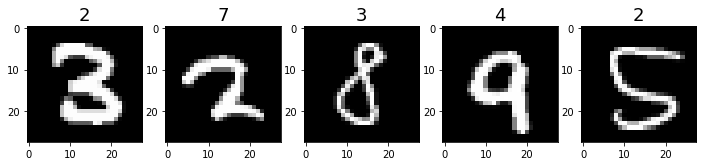

In [561]:
predicted_labels = hidden_do.predict_classes(validation_images, batch_size=32)
errors = np.where(validation_labels != predicted_labels)[0][:5]
display_images(validation_images[errors], predicted_labels[errors])

## Convolution

In [ ]:
# TODO